Winter Semester 2020/21, M.Sc. Economics | University of Bonn | [Madhurima Chandra](https://github.com/mchandra12)

# Testing optimization algorithms supported in estimagic - Scientific Computing Project

This notebook presents an overview of my project on extending the testing suite for optimization algorithms supported in the python package [estimagic](https://github.com/OpenSourceEconomics/estimagic). Benchmarking the algorithms against three critical functions - trid, rotated hyper ellipsoid and rosenbrock and also ten different types of constraints, we discuss how different optimization algorithms perform in terms of accuracy. Additionally, in this notebook I also consider their performance with respect to number of criterion evaluations required to reach the optima. This project involved primarily three steps, and my contributions are organized into three corresponding files linked below.

Links to code files and documentation that together form the core of my project (please view them in this order):
1. [Implement benchmark functions for testing of algorithms](https://github.com/OpenSourceEconomics/estimagic/blob/new_tests_optimization/estimagic/examples/criterion_functions_optimization_tests.py)
2. [Write test functions using the pytest (specially pytest.mark.parametrize) framework](https://github.com/OpenSourceEconomics/estimagic/blob/new_tests_optimization/estimagic/tests/optimization/test_other_criterion_functions.py)
3. [Add a section to estimagic's documentation on the testing of optimization algorithms](https://github.com/OpenSourceEconomics/estimagic/blob/new_tests_optimization/docs/source/explanations/optimization/tests_for_supported_optimizers.rst)

All the above files are located in the branch called ``new_tests_optimization`` in estimagic, see [here](https://github.com/OpenSourceEconomics/estimagic/tree/new_tests_optimization).

## Table of Contents

[1. Implement benchmark functions for testing of algorithms](#sec1) 

 - [1.1 Trid function](#sec11)
 - [1.2 Rotated Hyper Ellipsoid function](#sec12)
 - [1.3 Rosenbrock function](#sec13)

[2. Write test functions using the pytest framework](#sec2)

 - [2.1 Analytical solutions to all optimization problems considered in the project](#sec21)
 - [2.2 Algorithms considered](#sec22)
 - [2.3 Discussion on test results](#sec23)

[3. Additional Visualizations: Compare algorithms on criterion-evaluations](#sec3)
 - [3.1 Case 1: No constraints ](#sec31)
 - [3.2 Case 2: Imposing Equality constraint](#sec32)
 - [3.3 Case 3: Imposing Linear constraint](#sec33)
 
[4. Brief summary of contributions](#sec4)

In [1]:
import numpy as np
import pandas as pd

---
<a id='sec1'></a>
# 1. Implement benchmark functions for testing of algorithms 
---

We implement each function and its gradient in different ways, taking
into account the types of objective functions that estimagic's
``minimize`` and ``maximize`` accepts  for optimization. All algorithms accept
criterion functions specified in a dictionary, while a subset also accept the criterion
specified in scalar form. Likewise, if specified, the gradient of a criterion can be
an np.ndarray or a pandas object. We test for all possible cases.
For instance, for rotated hyper ellipsoid, we implement the following functions:

* rotated_hyper_ellipsoid_scalar_criterion
* rotated_hyper_ellipsoid_dict_criterion: This provides a dictionary wherein the
  ``contributions`` and ``root_contributions`` keys present the criterion as a least
  squares problem, relevant when we are testing a least squares algorithm.
* rotated_hyper_ellipsoid_gradient
* rotated_hyper_ellipsoid_pandas_gradient: Computes the gradient of the rotated hyper
  ellipsoid function, as a pandas object.
* rotated_hyper_ellipsoid_criterion_and_gradient

The code block below serves as an illustrative example for one criterion. All other function implementations can be found in the ``examples`` directory, in ``criterion_functions_optimization_tests.py``.

In [2]:
def rotated_hyper_ellipsoid_scalar_criterion(params):
    """ Implement Rotated Hyper Ellipsoid function.
    Function description: https://www.sfu.ca/~ssurjano/rothyp.html.
    
    Args:
        params (pd.DataFrame): Must have the column "value" containing
        input values for parameters. Accepts arbitrary numbers of input values.
        
    Returns:
        int: Rotated Hyper Ellipsoid function output.
    """
    val = 0
    for i in range(len(params["value"])):
        val += (params["value"][: i + 1] ** 2).sum()
    return val


def rotated_hyper_ellipsoid_gradient(params):
    """Calculate gradient of rotated_hyper_ellipsoid function.
    
    Args:
        params(pandas.DataFrame): Must have the column "value" containing
        input values for parameters. Accepts arbitrary numbers of input values.
    
    Returns:
        np.ndarray: gradient of rotated hyper ellipsoid function.
    """
    
    x = params["value"].to_numpy()
    return np.arange(2 * len(x), 0, -2) * x


def rotated_hyper_ellipsoid_pandas_gradient(params):
    """Calculate gradient of rotated_hyper_ellipsoid function.
    
    Args:
        params(pandas.DataFrame): Must have the column "value" containing
        input values for parameters. Accepts arbitrary numbers of input values.
    
    Returns:
        pd.Series: gradient of rotated hyper ellipsoid function.
    """
    x = params["value"].to_numpy()
    return pd.Series(np.arange(2 * len(x), 0, -2) * x)


def rotated_hyper_ellipsoid_criterion_and_gradient(params):
    """ Implement Rotated Hyper Ellipsoid function and calculate gradient.
    
    Args:
        params (pd.DataFrame): Must have the column "value" containing
        input values for parameters. Accepts arbitrary numbers of input values.
        
    Returns:
        int: Rotated Hyper Ellipsoid function output.
        np.ndarray: gradient of rotated hyper ellipsoid function.
    """
    val = 0
    for i in range(len(params["value"])):
        val += (params["value"][: i + 1] ** 2).sum()
    x = params["value"].to_numpy()
    return val, np.arange(2 * len(x), 0, -2) * x


def rotated_hyper_ellipsoid_contributions(params):
    """ Compute contributions of Rotated Hyper Ellipsoid function.
    
    Args:
        params (pd.DataFrame): Must have the column "value" containing
        input values for parameters. Accepts arbitrary numbers of input values.
        
    Returns:
        np.ndarray: array with contributions of function output as elements.
    """
    x = params["value"].to_numpy()
    dim = len(params)
    out = np.zeros(dim)
    for i in range(dim):
        out[i] = (x[: i + 1] ** 2).sum()
    return out


def rotated_hyper_ellipsoid_dict_criterion(params):
    """Implement Rotated Hyper Ellipsoid function and compute
        contributions and root_contributions.
    
    Args:
        params(pandas.DataFrame): Must have the column "value" containing
        input values for parameters. Accepts arbitrary numbers of input values.
    
    Returns:
        Dictionary with the following entries:
        "value" (a scalar float): rotated hyper ellipsoid function output.
        "contributions" (np.ndarray): array with contributions of function output as elements.
        "root_contributions" (np.ndarray): array with root of contributions of function output as elements. 
    """
    out = {
        "value": rotated_hyper_ellipsoid_scalar_criterion(params),
        "contributions": rotated_hyper_ellipsoid_contributions(params),
        "root_contributions": np.sqrt(rotated_hyper_ellipsoid_contributions(params)),
    }
    return out


---
<a id='sec11'></a>
### 1.1 Trid function
---


$$f({x}) = \Sigma^{D}_{i=1}(x_{i} - 1)^2 - \Sigma^{D}_{i=2}(x_i x_{i-1})$$

The Trid function has no local minimum except the global one. It is also the only function amongst the ones we consider in the project whcih cannot be expressed as a least squares problem. Hence, I do not generate testcases that involve optimizing this function using a least squares algorithm (``nag_dfols``).   

Gradient (dimendion = d) :

\begin{gather}
  \begin{bmatrix}
   2(x_{1}-1) - x_{2} \\
   2(x_{2}-1) - x_{1} - x_{3} \\
   2(x_{3}-1) - x_{2} - x_{4} \\
   ... \\
   ... \\
   ... \\
   ... \\
   2(x_{d}-1) - x_{d-1} 
   \end{bmatrix}
\end{gather}

---
<a id='sec12'></a>
### 1.2 Rotated Hyper Ellipsoid function
---


$$ f({x}) = \Sigma^{D}_{i=1} \Sigma^{i}_{j=1}x_j^2 $$

This is another standard function for testing optimization algorithms.   
Global Minima: at $(0, 0, 0, ...)$

Gradient (dimendion = d) :
\begin{gather}
  \begin{bmatrix}
   8x_{1} \\
   6x_{2}\\
   4x_{3} \\
   ... \\
   ... \\
   ... \\
   2x_{d} \\
   \end{bmatrix}
\end{gather}

---
<a id='sec13'></a>
### 1.3 Rosenbrock function
---

$$\Sigma^{D-1}_{i=1}(100(x_i+1 - x_i^2)^2 + (x_i - 1)^2)$$

This function, interestingly, seems to give our algorithms the hardest time. As I will discuss in a later section, for several algorithms, testcases involving rosenbrock fail since they could not accurately find the optima within a reasonable tolerance. This function's global minimum lies in a narrow, parabolic valley which is easy to find, but convergence to the minimum is difficult.    
Global Minima: at $(1, 1, 1, ...)$

Gradient (dimendion = d) :

\begin{gather}
  \begin{bmatrix}
   100(4x_1^3 - 4x_2 x_1) + 2x_1 - 2 \\
   100(2x_{2} - 2x_{1}^2 + 4x_2^3 - 4x_3 x_2) + 2x_2 - 2 \\
   100(2x_{3} - 2x_{2}^2 + 4x_3^3 - 4x_4 x_3) + 2x_3 - 2 \\
   ... \\
   ... \\
   ... \\
   100(2x_{d} - 2x_{d-1}^2)
   \end{bmatrix}
\end{gather}

---
<a id='sec2'></a>
# 2. Write test functions using the pytest framework
---

For testing the external interface, we write several test functions, each considering the
case of one constraint. Given the constraint, the test function considers all possible
combinations of - algorithm, to maximize or to minimize, criterion function
implementation, gradient function implementation for that criterion (if provided),
and whether ``criterion_and_derivative`` has been provided or not. 

In total, the file test_other_criterion_functions.py runs 3620 test cases (10 test functions, each function running 362 test cases). 
The best way to visualize these tests 'in action' is to call ``pytest test_other_criterion_functions.py`` in the terminal, after switching to the correct directory. Certain testcases have been xfailed/skipped, they are for those cases where either the algorithm fails at its specified tolerance level or where the true analytical solution is not known.

Below we show the calculations behind the true values, for each testcase (one criterion
and one constraint). The test functions compare these values with the solutions returned
by the algorithms, for each corresponding testcase. For a detailed exposition on different constraint types that are tested in this project, see [here](https://estimagic.readthedocs.io/en/latest/how_to_guides/optimization/how_to_specify_constraints.html).

---
<a id='sec21'></a>
## 2.1 Analytical solutions to all optimization problems considered in the project
---

For our test cases, we set the number of dimensions to be equal to 3. For five of the cases (here, a case refers to a constraint-criterion combination) below, the true analytical solution is not known to me. On running ``pytest``, these test cases are skipped.

- **Trid function**

1. No constraints case:

    $ x* = (3, 4, 3) $


2. Fixed constraint: (fix the first parameter to 1)

   $ x_{1} = 1 \rightarrow f(x) = (x_2 - 1)^2 + (x_3 - 1)^2 - x_2 - x_3 x_2 \\
   \Rightarrow \frac{\delta f({x})}{\delta x_2} = 2x_2 - 3 - x_3 = 0
   \Rightarrow x_3 = 2x_2 - 3\\
   \Rightarrow \frac{\delta f({x})}{\delta x_3} = 2x_3 - 2 - x_2 = 0
   \Rightarrow x_2 = 2x_3 - 2\\
   \Rightarrow x_2 = \frac{8}{3} , \quad x_3 = \frac{7}{3}\\
   \rightarrow x* = (1,\frac{8}{3}, \frac{7}{3}) $


3. Probability constraint:

   $ x_{1} + x_{2} = 1, \quad 0 \leq x_1 \leq 1, \quad 0 \leq x_2 \leq 1 \\
   \rightarrow f({x}) = 3x_1^2 - 3x_1 - 3x_3 + x_3^2 + x_1 x_3 + 2 \\
   \Rightarrow \frac{\delta f({x})}{\delta x_1} = 6x_1 - 3 + x_3 = 0
   \Rightarrow x_3 = 3 - 6x_1\\
   \Rightarrow \frac{\delta f({x})}{\delta x_3} = 2x_3 - 3 + x_1 = 0
   \Rightarrow x_1 = 3 - 2x_3\\
   \Rightarrow x_1 = \frac{3}{11}, \quad x_3 = \frac{15}{11}\\
   \rightarrow x* = (\frac{3}{11}, \frac{8}{11}, \frac{15}{11}) $


4. Increasing constraint:

    $ {L}({x_i}) = (x_1 - 1)^2 + (x_2 - 1)^2 + (x_3 - 1)^2 - x_1 x_2 - x_3 x_2 - \lambda(x_3 - x_2)\\
    \Rightarrow \frac{\delta \mathcal{L}}{\delta x_1} = 2(x_1 - 1) - x_2 = 0\\
    \Rightarrow \frac{\delta \mathcal{L}}{\delta x_2} = 2(x_2 - 1) - x_1 - x_3 + \lambda = 0\\
    \Rightarrow \frac{\delta \mathcal{L}}{\delta x_3} = 2(x_3 - 1) - x_2 - \lambda = 0\\
    \Rightarrow \frac{\delta \mathcal{L}}{\delta \lambda} = - x_3 + x_2 = 0\\
    \Rightarrow x_2 = 2(x_1 - 1) = x_3 = \frac{10}{3}\\
    \Rightarrow 2(x_2 - 1) - x_1 - 2 = 0\\
    \Rightarrow 4(x_1 - 1) - 2 - x_1 - 2 = 0\\
    \Rightarrow 3x_1 - 8 = 0 \Rightarrow x_1 = \frac{8}{3}\\
    \rightarrow x* = (\frac{8}{3}, \frac{10}{3}, \frac{10}{3}) $


5. Decreasing constraint:

   No solution available.


6. Equality constraint:

   $ x_{1} = x_{2} = x_{3} = x \\
   \rightarrow f({x}) = x^2 - 6x + 3\\
   \Rightarrow \frac{\delta f({x})}{\delta x} = 2x - 6 = 0\\
   \Rightarrow x = 3\\
   \rightarrow x* = (3,3,3) $


7. Pairwise equality constraint:


$ x_{1} = x_{2} \\
\rightarrow f({x}) = 2(x_1 - 1)^2 + (x_3 - 1)^2 - x_1^2 - x_3 x_1\\
\Rightarrow \frac{\delta f({x})}{\delta x_1} = 2x_1 - x_3 - 4 = 0 \Rightarrow x_3 = 2x_1 - 4\\
\Rightarrow \frac{\delta f({x})}{\delta x_3} = 2x_3 - x_1 - 2 = 0 \Rightarrow x_1 = 2x_3 - 2\\
\Rightarrow x_1 = \frac{10}{3}, x_3 = \frac{8}{3}\\
\rightarrow x* = (\frac{10}{3},\frac{10}{3},\frac{8}{3}) $


8. Covariance constraint: 

    No solution available.


9. Sdcorr constraint:

    No solution available.


10. Linear constraint:

    $ x_1 + 2x_2 = 4\\
    \mathcal{L}({x_i}) = (x_1 - 1)^2 + (x_2 - 1)^2 + (x_3 - 1)^2 - x_1 x_2 - x_3 x_2 - \lambda(x_1 +2x_2-4)\\
    \Rightarrow \frac{\delta \mathcal{L}}{\delta x_1} = 2(x_1 - 1) - x_2 - \lambda = 0\\
    \Rightarrow \frac{\delta \mathcal{L}}{\delta x_2} = 2(x_2 - 1) - x_1 - x_3 - 2\lambda = 0\\
    \Rightarrow \frac{\delta \mathcal{L}}{\delta x_3} = 2(x_3 - 1) - x_2 = 0 \\
    \Rightarrow \frac{\delta \mathcal{L}}{\delta \lambda} = - x_1 - 2x_2 + 4 = 0\\
    \Rightarrow x_2 = 2(x_3 - 1), \quad x_1 = 4 - 2x_2\\
    \Rightarrow 2(4 - 2x_2 - 1) - x_2 = x_2 - 1 - 2 + x_2 - \frac{x_2}{4} - \frac{1}{2}\\
    \rightarrow x* = (\frac{32}{27}, \frac{38}{27}, \frac{46}{27}) $



- **Rotated Hyper Ellipsoid function**

1. No constraints case:

     $ x* = (0, 0, 0) $


   2. Fixed constraint: 

       $ x_{1} = 1 \rightarrow x* = (1, 0, 0) $


   3. Probability constraint: 

        $ x_{1} + x_{2} = 1, \quad 0 \leq x_1 \leq 1, \quad 0 \leq x_2 \leq 1 \\\mathcal{L}({x_i}) = x^2_1 + (x^2_1 + x^2_2) + (x^2_1 + x^2_2 + x^2_3) -\lambda(x_1 +x_2-1)\\ \Rightarrow \frac{\delta \mathcal{L}}{\delta x_1} = 6x_1 - \lambda = 0\\ \Rightarrow \frac{\delta \mathcal{L}}{\delta x_2} = 4x_2 - \lambda = 0\\ \Rightarrow \frac{\delta \mathcal{L}}{\delta x_3} = 2 x_3 = 0\\ \Rightarrow \frac{\delta \mathcal{L}}{\delta \lambda} = -x_1 - x_2 + 1 = 0\\ \rightarrow x* = (\frac{2}{5}, \frac{3}{5}, 0),\quad f({x*}) = \frac{6}{5} $


   4. Increasing constraint: 

       Not binding $ \rightarrow x* = (0, 0, 0) $


   5. Decreasing constraint: 

       Not binding $ \rightarrow x* = (0, 0, 0) $


   6. Equality constraint: 

       Not binding $ \rightarrow x* = (0, 0, 0) $


   7. Pairwise equality constraint: 

       Not binding $ \rightarrow x* = (0, 0, 0) $


   8. Covariance constraint: 

       Not binding $ \rightarrow x* = (0, 0, 0) $


   9. Sdcorr constraint: 

       Not binding $ \rightarrow x* = (0, 0, 0) $


   10. Linear constraint:
        $ x_1 + 2x_2 = 4\\\mathcal{L}({x_i}) = x^2_1 + (x^2_1 + x^2_2) + (x^2_1 + x^2_2 + x^2_3) -\lambda(x_1 +2x_2-4)\\ \Rightarrow \frac{\delta \mathcal{L}}{\delta x_1} = 6x_1 - \lambda = 0\\ \Rightarrow \frac{\delta \mathcal{L}}{\delta x_2} = 4x_2 - 2\lambda = 0\\ \Rightarrow \frac{\delta \mathcal{L}}{\delta x_3} = 2 x_3 = 0\\ \Rightarrow \frac{\delta \mathcal{L}}{\delta \lambda} = -x_1 - 2x_2 + 4 = 0\\ \rightarrow x* = (\frac{4}{7}, \frac{12}{7}, 0) $


- **Rosenbrock function**

1. No constraints case:

     $ x* = (1, 1, 1) $

2. Fixed constraint:

    $ x_{1} = 1 \rightarrow x* = (1, 1, 1) $

3. Probability constraint:

    No solution available.

4. Increasing constraint:

    Not binding $ \rightarrow x* = (1, 1, 1) $


5. Decreasing constraint:

    Not binding $ \rightarrow x* = (1, 1, 1) $


6. Equality constraint:

    Not binding $ \rightarrow x* = (1, 1, 1) $


7. Pairwise equality constraint:

    Not binding $ \rightarrow x* = (1, 1, 1) $


8. Covariance constraint:

    Not binding $ \rightarrow x* = (1, 1, 1) $


9. Sdcorr constraint:

    Not binding $ \rightarrow x* = (1, 1, 1) $

10. Linear constraint:

    No solution available.


---
<a id='sec22'></a>
## 2.2 Algorithms considered
---

Due to runtime-related issues, running a large number of tests on every optimizer in estimagic was not feasible on my machine. Hence I consider a representative subset of six algorithms for testing - one non-linear least squares algorithm and a few from the ``scipy`` library. Currently, estimagic supports two least squares optimizers - ``nag_dfols`` and ``tao_pounders``. The latter only runs on Linux, so I included ``nag_dfols``.

On the ``scipy_truncated_newton`` algorithm: This is a gradient-descent algorithm. Initially this was also added to the set of optimizers being tested, however on running the tests it became clear that this algorithm was systematically failing every single test case wherein the gradient was not provided by the user. (In our testing suite we test each optimizer while providing gradient information and also, without specifying the gradient of the benchmark function.) This is somewhat expected behavior, since it is a gradient-based algorithm (though some gradient-based algorithms can also compute the derivative numerically when it is not user-provided).

Constraints are applicable only for algorithms that support bounds; all the algorithms I consider support bounds.

- scipy_lbfgsb
- scipy_slsqp
- scipy_powell
- scipy_trust_constr
- nag_pybobyqa
- nag_dfols

To run optimizations using ``nag_pybobyqa`` or ``nag_dfols``, additional dependencies need to be installed in your system. These dependencies are already provided in the environment file of this notebook's repository. Creating the environment from the environment file should suffice.

---
<a id='sec23'></a>
## 2.3 Discussion on test results
---

* For our three benchmark functions, the ``scipy_lbfgsb``, ``scipy_slsqp``, ``nag_pybobyqa`` and ``nag_dfols`` algorithms performed quite well. They passed (almost) every single test case, specially for the trid and rotated hyper ellipsoid functions.

* Relative to the above algorithms, ``scipy_powell`` and ``scipy_trust_constr`` were imprecise and required setting a different absolute tolerance level.

* Interestingly, ``scipy_lbfgsb`` fails the rosenbrock function with equality constraint case, though all other algorithms pass this test case. It does not fail this benchmark functions with other constraints. This has been xfailed.

* The rosenbrock function seems to be very effective as a benchmark. Numerous algorithms performing superbly for trid and rotated hyper ellipsoid functions, fail when it comes to rosenbrock.

* Each test function took around 2 minutes to run except the fixed_constraint test function which took ~1.5 hours to run on my machine. This is because for the rosenbrock function with fixed constraint, ``scipy_powell`` and ``scipy_trust_constr`` optimizers took a very long time to converge. Other algorithms performed fine in terms of speed, for this test case.

* For ``scipy_truncated_newton`` and other gradient-based optimizers, perhaps the test case involving not specifying the gradient information should be skipped. Gradient-based algorithms are not designed for that problem. They perform significantly better when it is specified.

---
<a id='sec3'></a>
# 3. Additional Visualizations: Compare algorithms on criterion-evaluations
---
We have seen how the given algorithms fared in accuracy against our benchmark criterion functions, now let us additionally consider their performance using another metric - number of criterion evaluations an algorithm requires to reach the optima.

In [3]:
# Import all criterion fucntion implementations, to be used for visualizations

from estimagic.examples.criterion_functions_optimization_tests import (
    rosenbrock_criterion_and_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rosenbrock_dict_criterion,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rosenbrock_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rosenbrock_pandas_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rosenbrock_scalar_criterion,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rotated_hyper_ellipsoid_criterion_and_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rotated_hyper_ellipsoid_dict_criterion,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rotated_hyper_ellipsoid_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rotated_hyper_ellipsoid_pandas_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rotated_hyper_ellipsoid_scalar_criterion,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    trid_criterion_and_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    trid_dict_criterion,
)
from estimagic.examples.criterion_functions_optimization_tests import trid_gradient
from estimagic.examples.criterion_functions_optimization_tests import (
    trid_pandas_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    trid_scalar_criterion,
)
from estimagic.optimization.optimize import maximize
from estimagic.optimization.optimize import minimize

In [4]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [5]:
# List of algorithms tested
rep_algo_list = [
    "scipy_lbfgsb",
    "scipy_slsqp",
    "nag_pybobyqa",
    "nag_dfols",
    "scipy_powell",
    "scipy_trust_constr",
]

# Since Trid function cannot be represented as a least squares problem, we skip the ``nag_dfols`` algorithm for Trid.
rep_algo_list_trid = [
    "scipy_lbfgsb",
    "scipy_slsqp",
    "nag_pybobyqa",
    "scipy_powell",
    "scipy_trust_constr",
]

## Case 1: No-constraint case

In [6]:
params = pd.DataFrame(data=np.array([1, 2, 3]), columns=["value"])
params["lower_bound"] = -np.inf
params["upper_bound"] = np.inf

### Trid

Text(0.5, 1.0, 'Trid Function: No constraints')

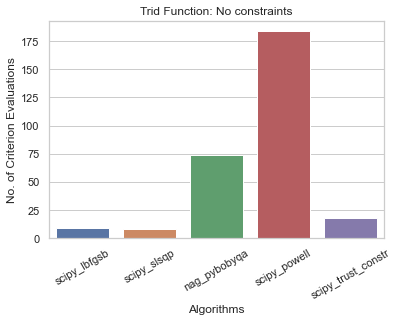

In [7]:
res = {}
for alg in rep_algo_list_trid:
    res[alg] = minimize(
        criterion=trid_dict_criterion,
        params=params,
        algorithm=alg,
        derivative=trid_gradient,
        criterion_and_derivative=trid_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list_trid:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Trid Function: No constraints')

### Rotated Hyper Ellipsoid

Text(0.5, 1.0, 'Rotated Hyper Ellipsoid Function: No constraints')

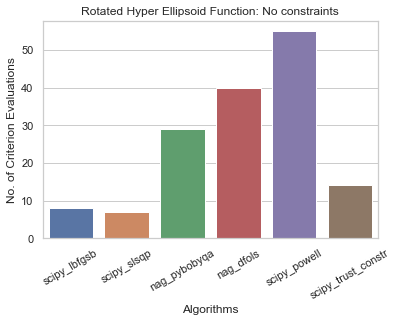

In [8]:
res = {}
for alg in rep_algo_list:
    res[alg] = minimize(
        criterion=rotated_hyper_ellipsoid_dict_criterion,
        params=params,
        algorithm=alg,
        derivative=rotated_hyper_ellipsoid_gradient,
        criterion_and_derivative=rotated_hyper_ellipsoid_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Rotated Hyper Ellipsoid Function: No constraints')

### Rosenbrock

Text(0.5, 1.0, 'Rosenbrock: No constraints')

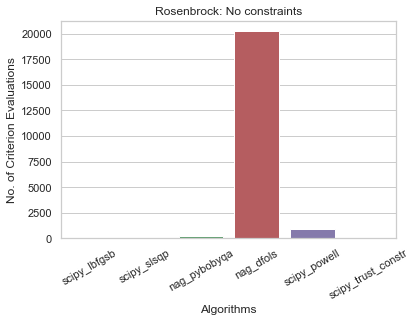

In [17]:
res = {}
for alg in rep_algo_list:
    res[alg] = minimize(
        criterion=rosenbrock_dict_criterion,
        params=params,
        algorithm=alg,
        derivative=rosenbrock_gradient,
        criterion_and_derivative=rosenbrock_criterion_and_gradient,
        logging=False,
    )
alg_n_eval = []
for alg in rep_algo_list:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Rosenbrock: No constraints')

For the case of no constraints, we see that ``scipy_powell`` requires the highest number of evaluations, across all criterion functions. An exceptional case is that of ``nag_dfols``: for the rosenbrock benchmark, the number of evaluations almost-explode into 20000, while other algorithms manage to stay well below 1000 evaluations for the same case.

## Case 2: Imposing Equality constraint

Next, let us explore some cases involving imposing constraints.

In [9]:
params_e = pd.DataFrame(data=[[2], [2], [2]], columns=["value"])
params_e["lower_bound"] = [-5, -5, -5]
params_e["upper_bound"] = -params["lower_bound"]

### Trid

Text(0.5, 1.0, 'Trid Function: Imposing Equality constraint')

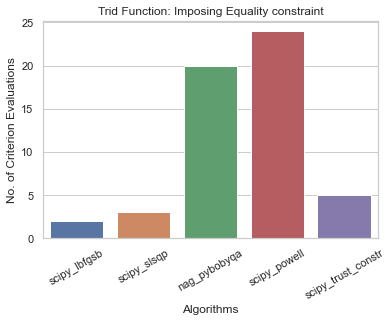

In [10]:
res = {}
for alg in rep_algo_list_trid:
    res[alg] = minimize(
        criterion=trid_dict_criterion,
        params=params_e,
        constraints = [{"loc": [0, 1, 2], "type": "equality"}],
        algorithm=alg,
        criterion_and_derivative=trid_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list_trid:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Trid Function: Imposing Equality constraint')

### Rotated Hyper Ellipsoid

Text(0.5, 1.0, 'Rotated Hyper Ellipsoid Function: Imposing Equality constraint')

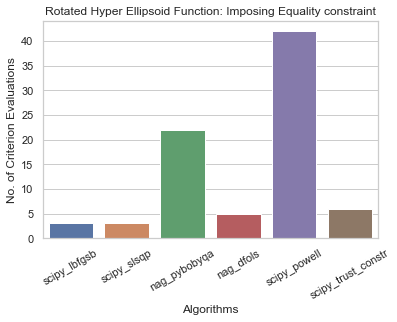

In [11]:
res = {}
for alg in rep_algo_list:
    res[alg] = minimize(
        criterion=rotated_hyper_ellipsoid_dict_criterion,
        params=params_e,
        constraints = [{"loc": [0, 1, 2], "type": "equality"}],
        algorithm=alg,
        criterion_and_derivative=rotated_hyper_ellipsoid_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Rotated Hyper Ellipsoid Function: Imposing Equality constraint')

### Rosenbrock

Text(0.5, 1.0, 'Rosenbrock Function: Imposing Equality constraint')

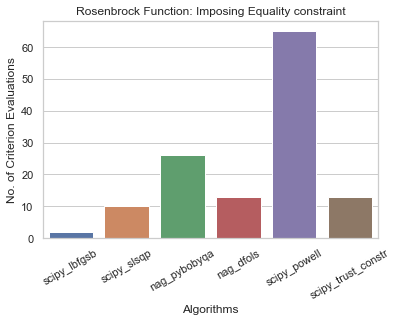

In [12]:
res = {}
for alg in rep_algo_list:
    res[alg] = minimize(
        criterion=rosenbrock_dict_criterion,
        params=params_e,
        constraints = [{"loc": [0, 1, 2], "type": "equality"}],
        algorithm=alg,
        criterion_and_derivative=rosenbrock_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Rosenbrock Function: Imposing Equality constraint')

- Recall from our tests that scipy_lbfgsb fails to find the optima for the rosenbrock-equality-constraint case, which is displayed here.
- We see a similar trend compared to the no-constraints case, that ``scipy_powell`` and ``nag_pybobyqa`` appear to take the highest number of evaluations to reach the optima.
- If we keep aside the exceptional case of ``nag_dfols`` and rosenbrock function presented above, we note that overall all algorithms seem to require a lower number of evaluations in this constrained case than the no-constraints case.

## Case 3: Imposing Linear constraint

In [13]:
params_l = pd.DataFrame(data=[[2], [1], [3]], columns=["value"])

### Trid

Text(0.5, 1.0, 'Trid Function: Imposing Linear constraint')

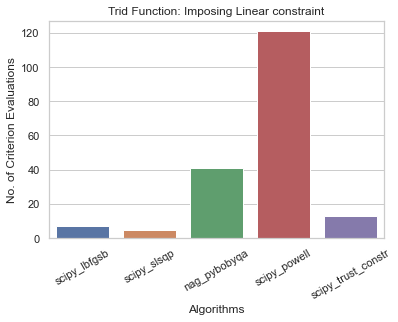

In [14]:
res = {}
for alg in rep_algo_list_trid:
    res[alg] = minimize(
        criterion=trid_dict_criterion,
        params=params_l,
        constraints = [{"loc": [0, 1], "type": "linear", "value": 4, "weights": [1, 2]}],
        algorithm=alg,
        criterion_and_derivative=trid_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list_trid:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Trid Function: Imposing Linear constraint')

### Rotated Hyper Ellipsoid

Text(0.5, 1.0, 'Rotated Hyper Ellipsoid Function: Imposing Linear constraint')

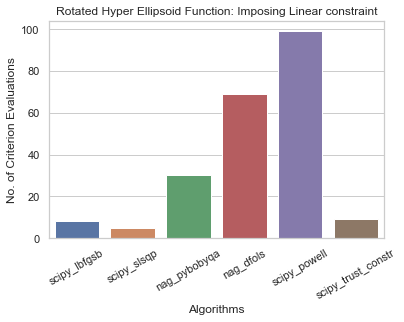

In [15]:
res = {}
for alg in rep_algo_list:
    res[alg] = minimize(
        criterion=rotated_hyper_ellipsoid_dict_criterion,
        params=params_l,
        constraints = [{"loc": [0, 1], "type": "linear", "value": 4, "weights": [1, 2]}],
        algorithm=alg,
        criterion_and_derivative=rotated_hyper_ellipsoid_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Rotated Hyper Ellipsoid Function: Imposing Linear constraint')

### Rosenbrock

Text(0.5, 1.0, 'Rosenbrock Function: Imposing Linear constraint')

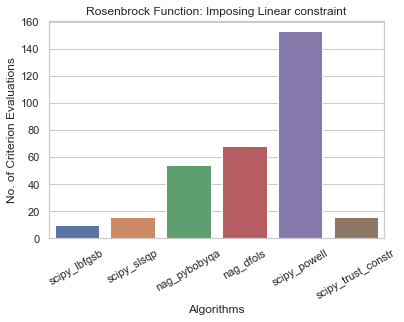

In [16]:
res = {}
for alg in rep_algo_list:
    res[alg] = minimize(
        criterion=rosenbrock_dict_criterion,
        params=params_l,
        constraints = [{"loc": [0, 1], "type": "linear", "value": 4, "weights": [1, 2]}],
        algorithm=alg,
        criterion_and_derivative=rosenbrock_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Rosenbrock Function: Imposing Linear constraint')

**Overview of results from visualizing function evaluations**

- Across all constraint specifications, we see that ``scipy-powell`` systematically displays much higher number of evaluations to reach the optima. 
- This is also in line with our test results - wherein we noted that for one test function, the two algorithms ``scipy-powell`` and ``scipy_trust_constr``required much longer time to run the test cases, compared to other algorithms. This led to a much higher runtime for the test function overall.
- From our small visualization exercise, it appears that``scipy_lbfgsb`` and ``scipy_slsqp`` are best-suited for optimizations where keeping the number of criterion evaluations to a minimum is a key factor.

---
<a id='sec4'></a>
# 4. Brief summary of contributions
---

- While working on this project, I found a bug due to which duplicate test cases were being generated. On some machines the pre-existing test file was running double the number of cases needed, also leading to a vast and unnecessary increase in running time for tests. With my pull request, this issue gets fixed (thanks to @janosg for help with this).
- This project extends the testing of the external interface of optimizers using new benchmark functions.
- This project highlights some accuracy-related issues for certain supported algorithms.
- Present a brief comparison of algorithm performance based on number of criterion evaluations.
- Contribution to documentation.